<a href="https://colab.research.google.com/github/HajarahM/HajarahM/blob/main/CodeLlama13BPythonGPTQ_EvaluateModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Model

### Install Library

In [ ]:
!pip install -U -q "langchain" "datasets==2.13.0" "peft==0.4.0" "bitsandbytes==0.40.2" "trl==0.4.7" "safetensors>=0.3.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q -U faiss-cpu tiktoken sentence-transformers einops huggingface-hub xformers auto-gptq optimum accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 36.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━

### Data Parsing

In [ ]:
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

import torch
from torch import cuda

import locale
locale.getpreferredencoding = lambda: "UTF-8"

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftConfig, PeftModel

In [ ]:
import pandas as pd

df = pd.read_csv("library_data.csv")
df.head()

,year,title_en,value
0,2014,General Information,55572
1,2014,Philosophy and psychology,31093
2,2014,Religions,127603
3,2014,Social Sciences,127795
4,2014,"Social Sciences, Business and Law",146


In [ ]:
library = CSVLoader("library_data.csv")

In [ ]:
library_data = library.load()

In [ ]:
library_data[0]

Document(page_content='year: 2014\ntitle_en: General Information\nvalue: 55572', metadata={'source': 'library_data.csv', 'row': 0})

### Text Splitter

In [ ]:
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter(
    chunk_size=1000,
    chunk_overlap = 200,
)

library_doc = text_splitter.split_documents(library_data)
library_doc[0]

Document(page_content='year: 2014\ntitle_en: General Information\nvalue: 55572', metadata={'source': 'library_data.csv', 'row': 0})

### Index / Vector Store

In [ ]:
# FAISS vectorstore
store = LocalFileStore("./cache/")

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device, 'batch_size': 32}
)

# saves time and money when user asks same question.
embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.from_documents(library_doc, embedder)

In [ ]:
#check if the vectorstore is working correctly.
query = "In python, write a code that reads the csv file and plot a scatter plot of x-axis labeled 'Year' and the y-axis labeled 'value'"

embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k=3)

for page in docs:
  print(page.page_content)

year: 2016
title_en: General Information
value: 57857
year: 2016
title_en: Pure Sciences
value: 3752
year: 2015
title_en: Others
value: 20501


In [ ]:
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 5})
docs = retriever.get_relevant_documents("In python, write a code that reads the csv file and plot a scatter plot of x-axis labeled 'Year' and the y-axis labeled 'value'")
docs

[Document(page_content='year: 2016\ntitle_en: General Information\nvalue: 57857', metadata={'source': 'library_data.csv', 'row': 40}),
 Document(page_content='year: 2016\ntitle_en: Health and Social Serices\nvalue: 29', metadata={'source': 'library_data.csv', 'row': 55}),
 Document(page_content='year: 2014\ntitle_en: Social Sciences\nvalue: 127795', metadata={'source': 'library_data.csv', 'row': 3}),
 Document(page_content='year: 2016\ntitle_en: Linguistics\nvalue: 30118', metadata={'source': 'library_data.csv', 'row': 48}),
 Document(page_content='year: 2016\ntitle_en: Pure Sciences\nvalue: 3752', metadata={'source': 'library_data.csv', 'row': 46})]

### Build a Retrieval Chain

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

###CodeLLama

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "TheBloke/CodeLlama-13B-Python-GPTQ"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,device_map='cuda')

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    return_full_text=True,
    temperature=0.0,
    max_new_tokens=1024,           #higher number of tokens delays the prompt
    repetition_penalty=1.1        # to avoid repeating
)

In [ ]:
result = generate_text("Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?")
result[0]["generated_text"]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


"Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?\n\n# In[10]:\n\n\ndf['title_en'].value_counts().plot(kind='bar')\nplt.show()\n\n\n# 12. Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?\n\n# In[11]:\n\n\ndf['title_en'].value_counts().plot(kind='bar', figsize=(15,8))\nplt.show()\n\n\n# 13. Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?\n\n# In[12]:\n\n\ndf['title_en'].value_counts().plot(kind='bar', figsize=(15,8), color='red')\nplt.show()\n\n\n# 14. Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?\n\n# In[13]:\n\n\ndf['title_en'].value_counts().plot(kind='barh', figsize=(15,8), color='red')\nplt.show()\n\n\n# 15. Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?\n\n# In[14]:

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

In [ ]:
from langchain import PromptTemplate, LLMChain

# template for an instruction with no input
prompt = PromptTemplate(
    input_variables=["instruction"],
    template="{instruction}"
)

llm_chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
print(llm_chain.predict(
    instruction="Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?"
).lstrip())

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


# In[10]:


df['title_en'].value_counts().plot(kind='bar')
plt.show()


# 12. Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?

# In[11]:


df['title_en'].value_counts().plot(kind='bar', figsize=(15,8))
plt.show()


# 13. Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?

# In[12]:


df['title_en'].value_counts().plot(kind='bar', figsize=(15,8), color='red')
plt.show()


# 14. Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?

# In[13]:


df['title_en'].value_counts().plot(kind='barh', figsize=(15,8), color='red')
plt.show()


# 15. Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?

# In[14]:


df['title_en'].value_counts().plot(kind='pie', figsize=(15,8), autopct='%1.1f%%', colors=['r','b','g'])
plt.show()


# 16. Write a code that plot a b

#### CodeLlama-RetrievalQA

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever
    )

In [ ]:
# #function to extract code from llm output
# import re
# import sys
# from io import StringIO

# def execute_code(text):
#     pattern = r'\\begin\{code\}(.*?)\\end\{code\}'                #extracts the code within \begin{code} and \end{code}
#     code_blocks = re.findall(pattern, text, re.DOTALL)

#     if not code_blocks:
#         return "Answer not found by LLM."

#     results = ""
#     globals_dict = {}
#     locals_dict = {}

#     for code_block in code_blocks:
#         try:
#             results += '\n'
#             exec(code_block, globals_dict, locals_dict)
#             result = None
#             for key, value in locals_dict.items():
#                 if not key.startswith("__"):
#                     result = value

#             results += f"Code Output:\n{result}\n\n"
#         except Exception as e:
#             results += f"Error executing code:\n{str(e)}\n\n"

#     return results

In [ ]:
def execute_code(code):
    # Remove "```python" at the beginning
    code = code.replace("```python", "")

    # Remove "```" at the end
    code = code.replace("```", "")
    code = code.split("###")[0]

    try:
      exec(code)
    except Exception as e:
      print(f"Error executing code:{str(e)}")
    return code

# Results

### 1. Plot a bar graph to display the value of Philosophy and psychology title_en over the years

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


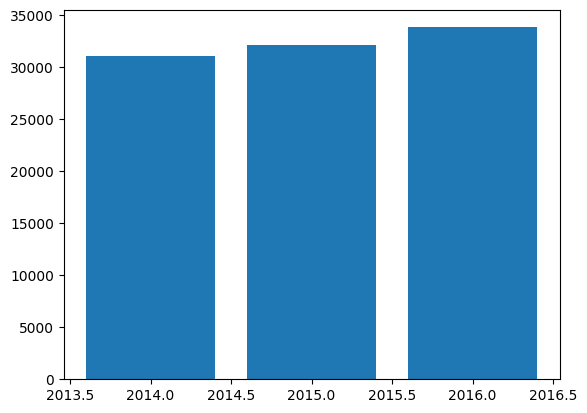



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df['title_en'] = df['title_en'].str.lower()

df = df[df['title_en'] == 'philosophy and psychology']

plt.bar(x=df['year'], height=df['value'])
plt.show()





In [ ]:
query = "Create Python code to generate a bar graph that visually represents the availability of books for the 'Philosophy and psychology' title_en over the years.Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 2. Plot the pie chart to display the distribution of books in public libraries of UAE in the year 2014.

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


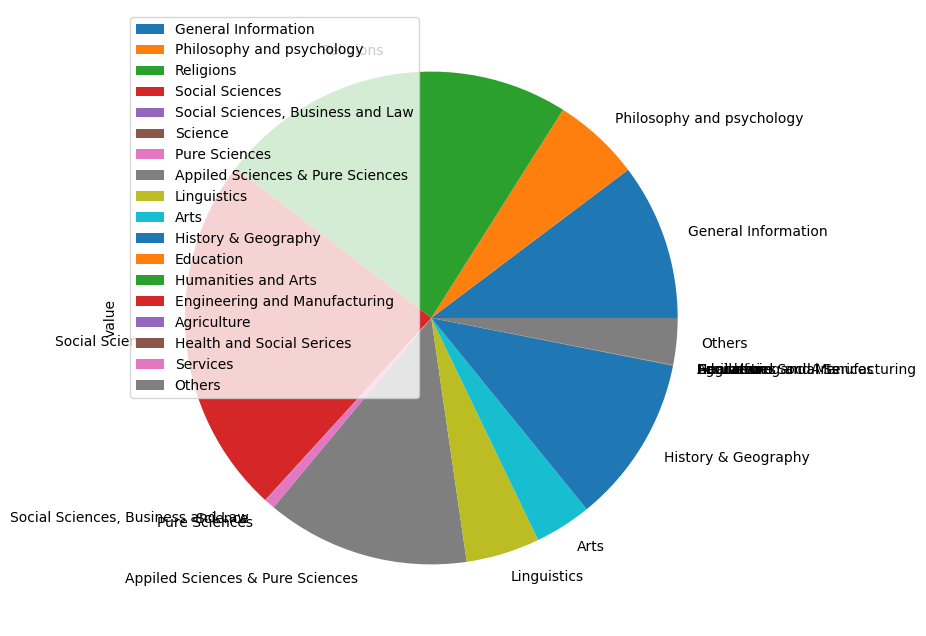




import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df[df['year'] == 2014].set_index('title_en').plot(kind='pie', y='value', figsize=(8, 8))
plt.show()




In [ ]:
query = "Create a Python code to generate a pie chart that visualizes the distribution of 'title_en' categories for the year 2014."

prompt = f'''Imagine you are a proficient Python coder with expertise in data visualization using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during a given year.

Ensure that your code is well-documented, includes axis labels, titles, and any other necessary components for a clear and informative visualization.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 3. Plot a multiple-line graph to display how the value of 'Linguistics' & 'Philosophy and psychology' title_en has trended over the years?

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


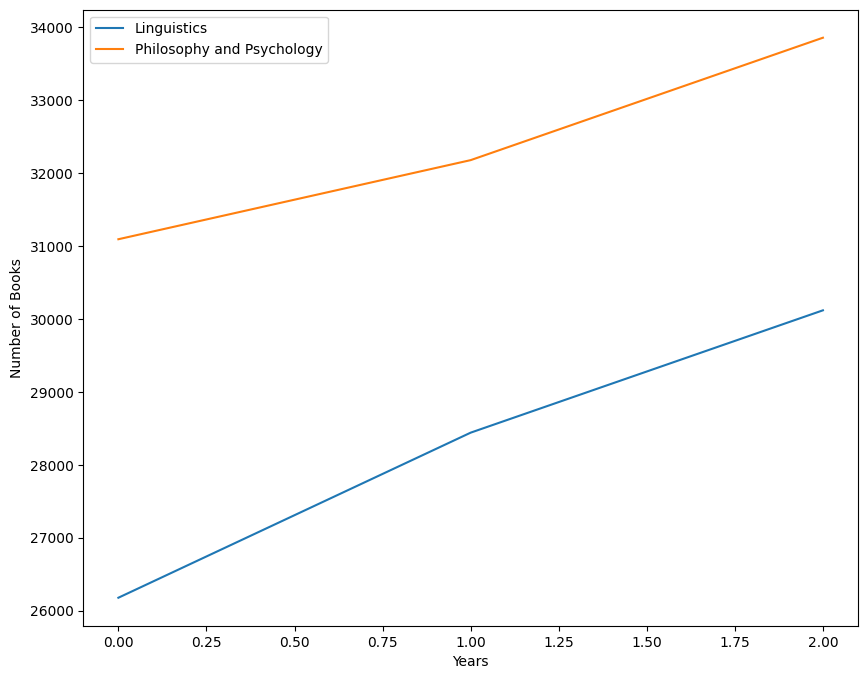



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

linguistics = df[df['title_en'] == 'Linguistics']['value'].values
philosophy_and_psychology = df[df['title_en'] == 'Philosophy and psychology']['value'].values

plt.figure(figsize=(10,8))
plt.plot(linguistics)
plt.plot(philosophy_and_psychology)
plt.legend(['Linguistics', 'Philosophy and Psychology'])
plt.xlabel('Years')
plt.ylabel('Number of Books')
plt.show()




In [ ]:
query = "Your task is to generate Python code to create a multiple line graph that illustrates the trends for the 'Linguistics' and 'Philosophy and psychology' title_en over the years. Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib.
You have access to a dataset stored in a CSV file, './library_data.csv,' which contains comprehensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure that your code is well-documented, includes axis labels, titles, and any other necessary components for a clear and informative visualization.

### Question: {query}
### Answer:'''


result = execute_code(qa.run(prompt))
print(result)

### 4. Plot multiple bar graph to display the value of 'Philosophy and psychology' and 'Religions' title_en over the years

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


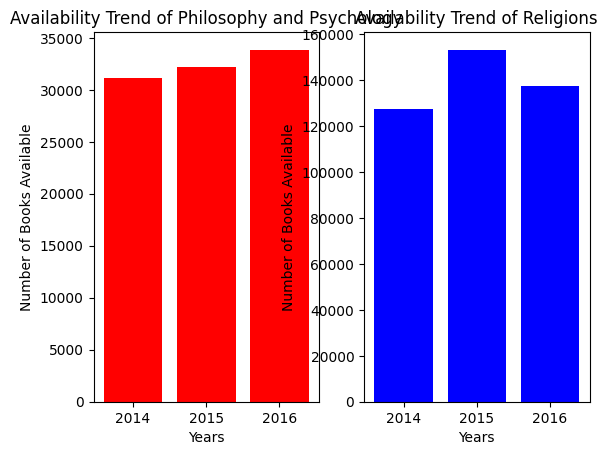




import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df['title_en'] = df['title_en'].str.lower()

df = df[df['title_en'].isin(['philosophy and psychology','religions'])]

df = df.groupby(by=['year','title_en'])['value'].sum().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].bar(x=df[df['title_en'] == 'philosophy and psychology']['year'], height=df[df['title_en'] == 'philosophy and psychology']['value'], color='red')
ax[0].set_title("Availability Trend of Philosophy and Psychology")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Number of Books Available")

ax[1].bar(x=df[df['title_en'] =='religions']['year'], height=df[df['title_en'] =='religions']['value'], color='blue')
ax[1].set_title("Availability Trend of Religions")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Number of Books Available")

plt.show()


In [ ]:
query = "Generate Python code to create multiple bar graphs showing the availability trends of 'Philosophy and psychology' and 'Religions' title_en over the years using Matplotlib."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 5. Plot a line graph to display how the value of 'General Information' title_en has trended over the years?

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(





import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

plt.figure(figsize=(10,8))
plt.xlabel("Year")
plt.ylabel("Number of Books")
plt.title("Trend for General Information")
plt.grid()
plt.plot(df[df['title_en'] == "General Information"]["year"], df[df['title_en'] == "General Information"]["value"])





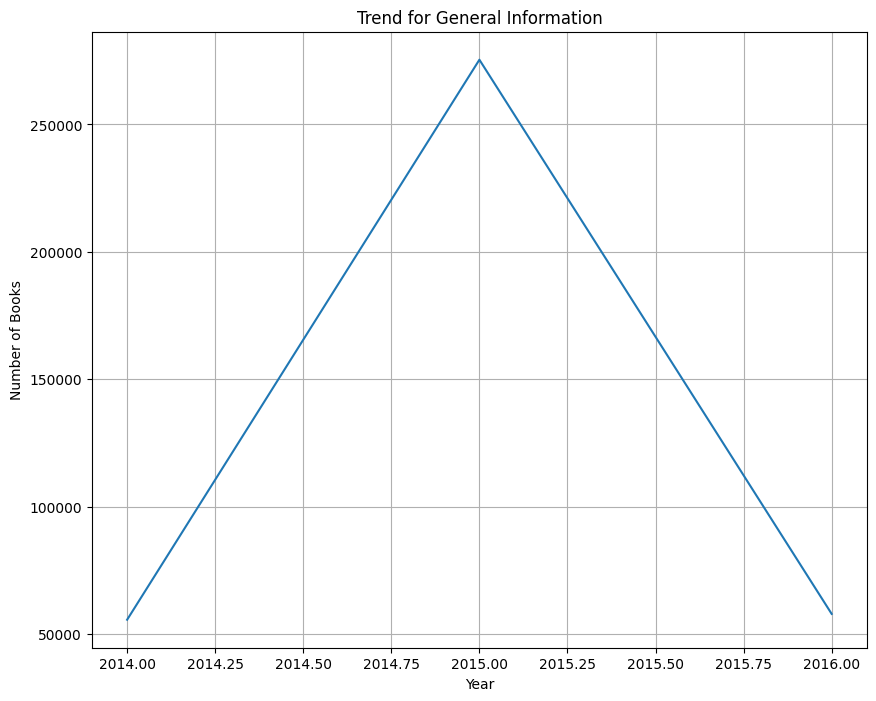

In [ ]:
query = "Generate Python code to create a line graph that specifically illustrates the trends for the 'General Information' title_en over the years."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 6. What are the top 5 titles that have most values in year 2014, and what are their values?

In [ ]:
query = "What are the top 5 title_en that have most values in year 2014, and what are their values?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


    year                          title_en   value
3   2014                   social sciences  127795
2   2014                         religions  127603
7   2014  appiled sciences & pure sciences   72222
10  2014               history & geography   59762
0   2014               general information   55572



import pandas as pd
df = pd.read_csv('./library_data.csv')
df['title_en'] = df['title_en'].str.lower()
df = df[df['year'] == 2014]
df = df.sort_values(by='value', ascending=False)
top_5 = df[:5].copy()
print(top_5)





### 7. What is the value when title_en is equal to 'Linguistics' in year '2016'?

In [ ]:
query = "What is the value when title_en is equal to 'Linguistics' in year '2016'?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(





import pandas as pd
df = pd.read_csv('./library_data.csv')
df[((df['year'] == 2016) & (df['title_en'] == 'Linguistics'))]['value'].values[0]





In [ ]:
import pandas as pd
df = pd.read_csv('./library_data.csv')
df[((df['year'] == 2016) & (df['title_en'] == 'Linguistics'))]['value'].values[0]

30118

### 8. What are the 5 title_en that have least values in year 2016, and what are their values?

In [ ]:
query = "What are the 5 title_en that have least values in year 2016, and what are their values?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(





import pandas as pd
df = pd.read_csv('./library_data.csv')
df['value'] = df['value'].astype(int)
df[df['year'] == 2016].sort_values(['value'], ascending=True).head()





In [ ]:
import pandas as pd
df = pd.read_csv('./library_data.csv')
df['value'] = df['value'].astype(int)
df[df['year'] == 2016].sort_values(['value'], ascending=True).head()

,year,title_en,value
54,2016,Agriculture,3
56,2016,Services,17
52,2016,Humanities and Arts,25
53,2016,Engineering and Manufacturing,27
55,2016,Health and Social Serices,29


### 9. Create Python code to generate a bar graph that visually represents different title_en values for the year 2015.

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


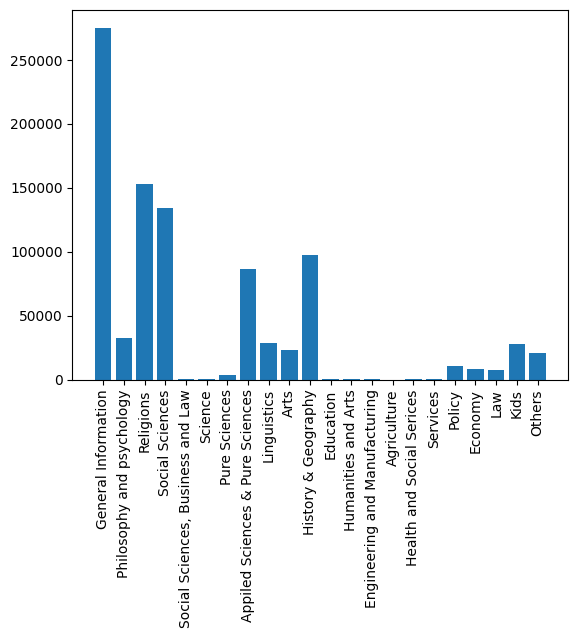



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df = df[df['year'] == 2015]

plt.bar(x=df['title_en'], height=df['value'])
plt.xticks(rotation=90)
plt.show()





In [ ]:
query = "Create Python code to generate a bar graph that visually represents different title_en values for the year 2015. Make sure that title_en names are clearly visible. Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)